In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import time
import random
from IPython.display import clear_output
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

pd.options.display.max_rows = 8000
pd.options.mode.chained_assignment=None

In [3]:
#Define directories

base = '/Users/Viktoria/Desktop/Mumsnet_Forumdata'
raw = os.path.join(base, 'Raw_data')
viz = os.path.join(base, 'Data_visualisation')
preproc = os.path.join(base, 'Preprocessed_data')

os.chdir(raw)

In [5]:
#Import data
forumdata = pd.read_csv('mumsnet_test.csv')
print(len(forumdata))
forumdata.head()

1463


,ID,Title,Forum,DateTime,Message
0,4160382,AIBU to ask where your buy your underwear?,am_i_being_unreasonable,2021-02-09 12:48:05.000 +0000,I bought these off Amazon - comfiest knickers ...
1,4159534,DH lost laptop and now assignment will be late,am_i_being_unreasonable,2021-02-08 20:32:56.000 +0000,Yay! Glad you found the laptop!\n\nPerhaps hav...
2,4160824,Best padded playmat company?,parenting,2021-02-09 21:28:03.000 +0000,Learn from my mistakes- they pull the tile kin...
3,4160824,Best padded playmat company?,parenting,2021-02-09 22:03:36.000 +0000,I got this one from Amazon:\n\n[[https://www.a...
4,4154319,What fun stuff can we get delivered for the fa...,_chat,2021-02-04 23:13:42.000 +0000,Chocolate fondue is cheaper than buying a choc...


In [6]:
#Anything missing?
forumdata.isnull().values.any()

False

In [7]:
#How many forums does the data come from?
len(forumdata.Forum.unique())

85

In [ ]:
#How many posts on each forum?
#forumdata.Forum.value_counts()

In [11]:
#Do all of these messages include a link?
recs = [m for m in forumdata.Message if 'amazon' in m]
print('Total number of messages: ', len(forumdata), '\nMessages with links: ', len(recs))

Total number of messages:  1463 
Messages with links:  1450


### 1.1. Which forums are the most likely to contain amazon recommendations?

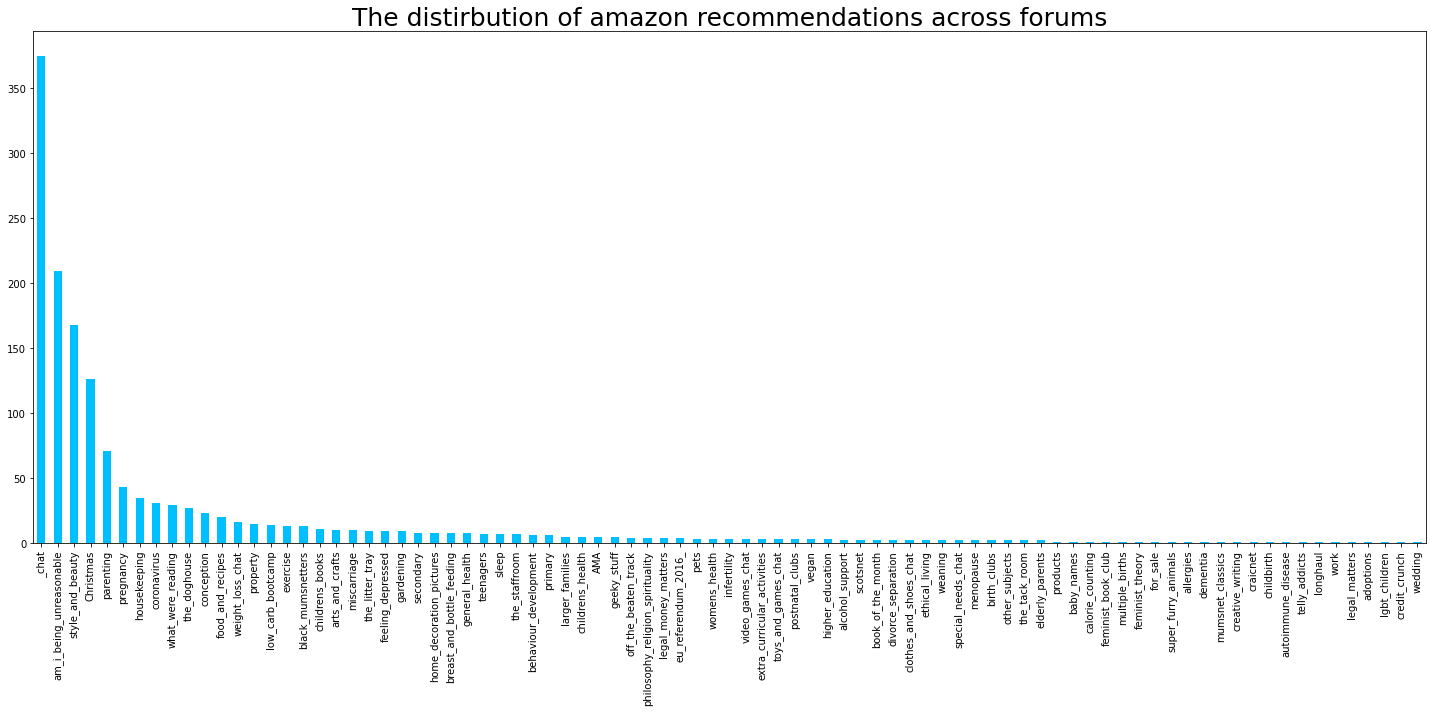

In [13]:
os.chdir(viz)

fora = forumdata.Forum.value_counts()
numfora = len(fora)

plt.figure(figsize=(20,10))
fora.plot.bar(width=0.5, color=(0, 0.75, 1)) #deep skye blue
plt.title('The distirbution of amazon recommendations across forums', fontsize=25)
plt.tight_layout()
plt.savefig('Number of messages across forums.pdf')

### When are people most likely to recommend products?


In [33]:
#Extract the hour:minute:second information from the timestamps

def get_hour(string):
    
    try:
        
        #Find the pattern hh:mm:ss
        time = re.search(r'[0-9]{2}\:[0-9]{2}\:[0-9]{2}', string).group() #gives None if no hits
        
        #Covert to a fraction between 0-24
        hour = int(time.split(':')[0])
        minute = int(time.split(':')[1])
        second = int(time.split(':')[2])
        TimeInHour = (hour*3600+minute*60+second)/3600
        
    except:
        TimeInHour = 'unknown'
        
    return TimeInHour

In [36]:
forumdata['Hours'] = forumdata['DateTime'].apply(get_hour)

In [37]:
forumdata.head()

,ID,Title,Forum,DateTime,Message,Hours
0,4160382,AIBU to ask where your buy your underwear?,am_i_being_unreasonable,2021-02-09 12:48:05.000 +0000,I bought these off Amazon - comfiest knickers ...,12.801389
1,4159534,DH lost laptop and now assignment will be late,am_i_being_unreasonable,2021-02-08 20:32:56.000 +0000,Yay! Glad you found the laptop!\n\nPerhaps hav...,20.548889
2,4160824,Best padded playmat company?,parenting,2021-02-09 21:28:03.000 +0000,Learn from my mistakes- they pull the tile kin...,21.467500
3,4160824,Best padded playmat company?,parenting,2021-02-09 22:03:36.000 +0000,I got this one from Amazon:\n\n[[https://www.a...,22.060000
4,4154319,What fun stuff can we get delivered for the fa...,_chat,2021-02-04 23:13:42.000 +0000,Chocolate fondue is cheaper than buying a choc...,23.228333


In [38]:
len(forumdata[forumdata.Hours=='unknown'])

0

In [39]:
times = forumdata.sort_values(by=['Hours'])
times = times.reset_index(drop=True)
times.head()

,ID,Title,Forum,DateTime,Message,Hours
0,4119327,Share your toys hits and misses here! (toddler...,parenting,2020-12-30 00:00:11.000 +0000,"Magnetic tiles have been a huge hit here too, ...",0.003056
1,4156404,Chick lit which ISNâ€™T first and foremost a r...,_chat,2021-02-06 00:02:36.000 +0000,[[https://www.amazon.co.uk/Prep-Curtis-Sittenf...,0.043333
2,4120949,Thread to discuss foreign reading,what_were_reading,2021-01-05 00:02:49.000 +0000,this one?\n[[https://www.amazon.co.uk/Great-Fr...,0.046944
3,4128158,What age did you get your toddler a pillow,parenting,2021-01-07 00:03:06.000 +0000,"I just gave dd a toddler pillow two days ago, ...",0.051667
4,4109377,Best fake AirPods please,Christmas,2020-12-19 00:05:09.000 +0000,If they don't have to look identical [[https:/...,0.085833


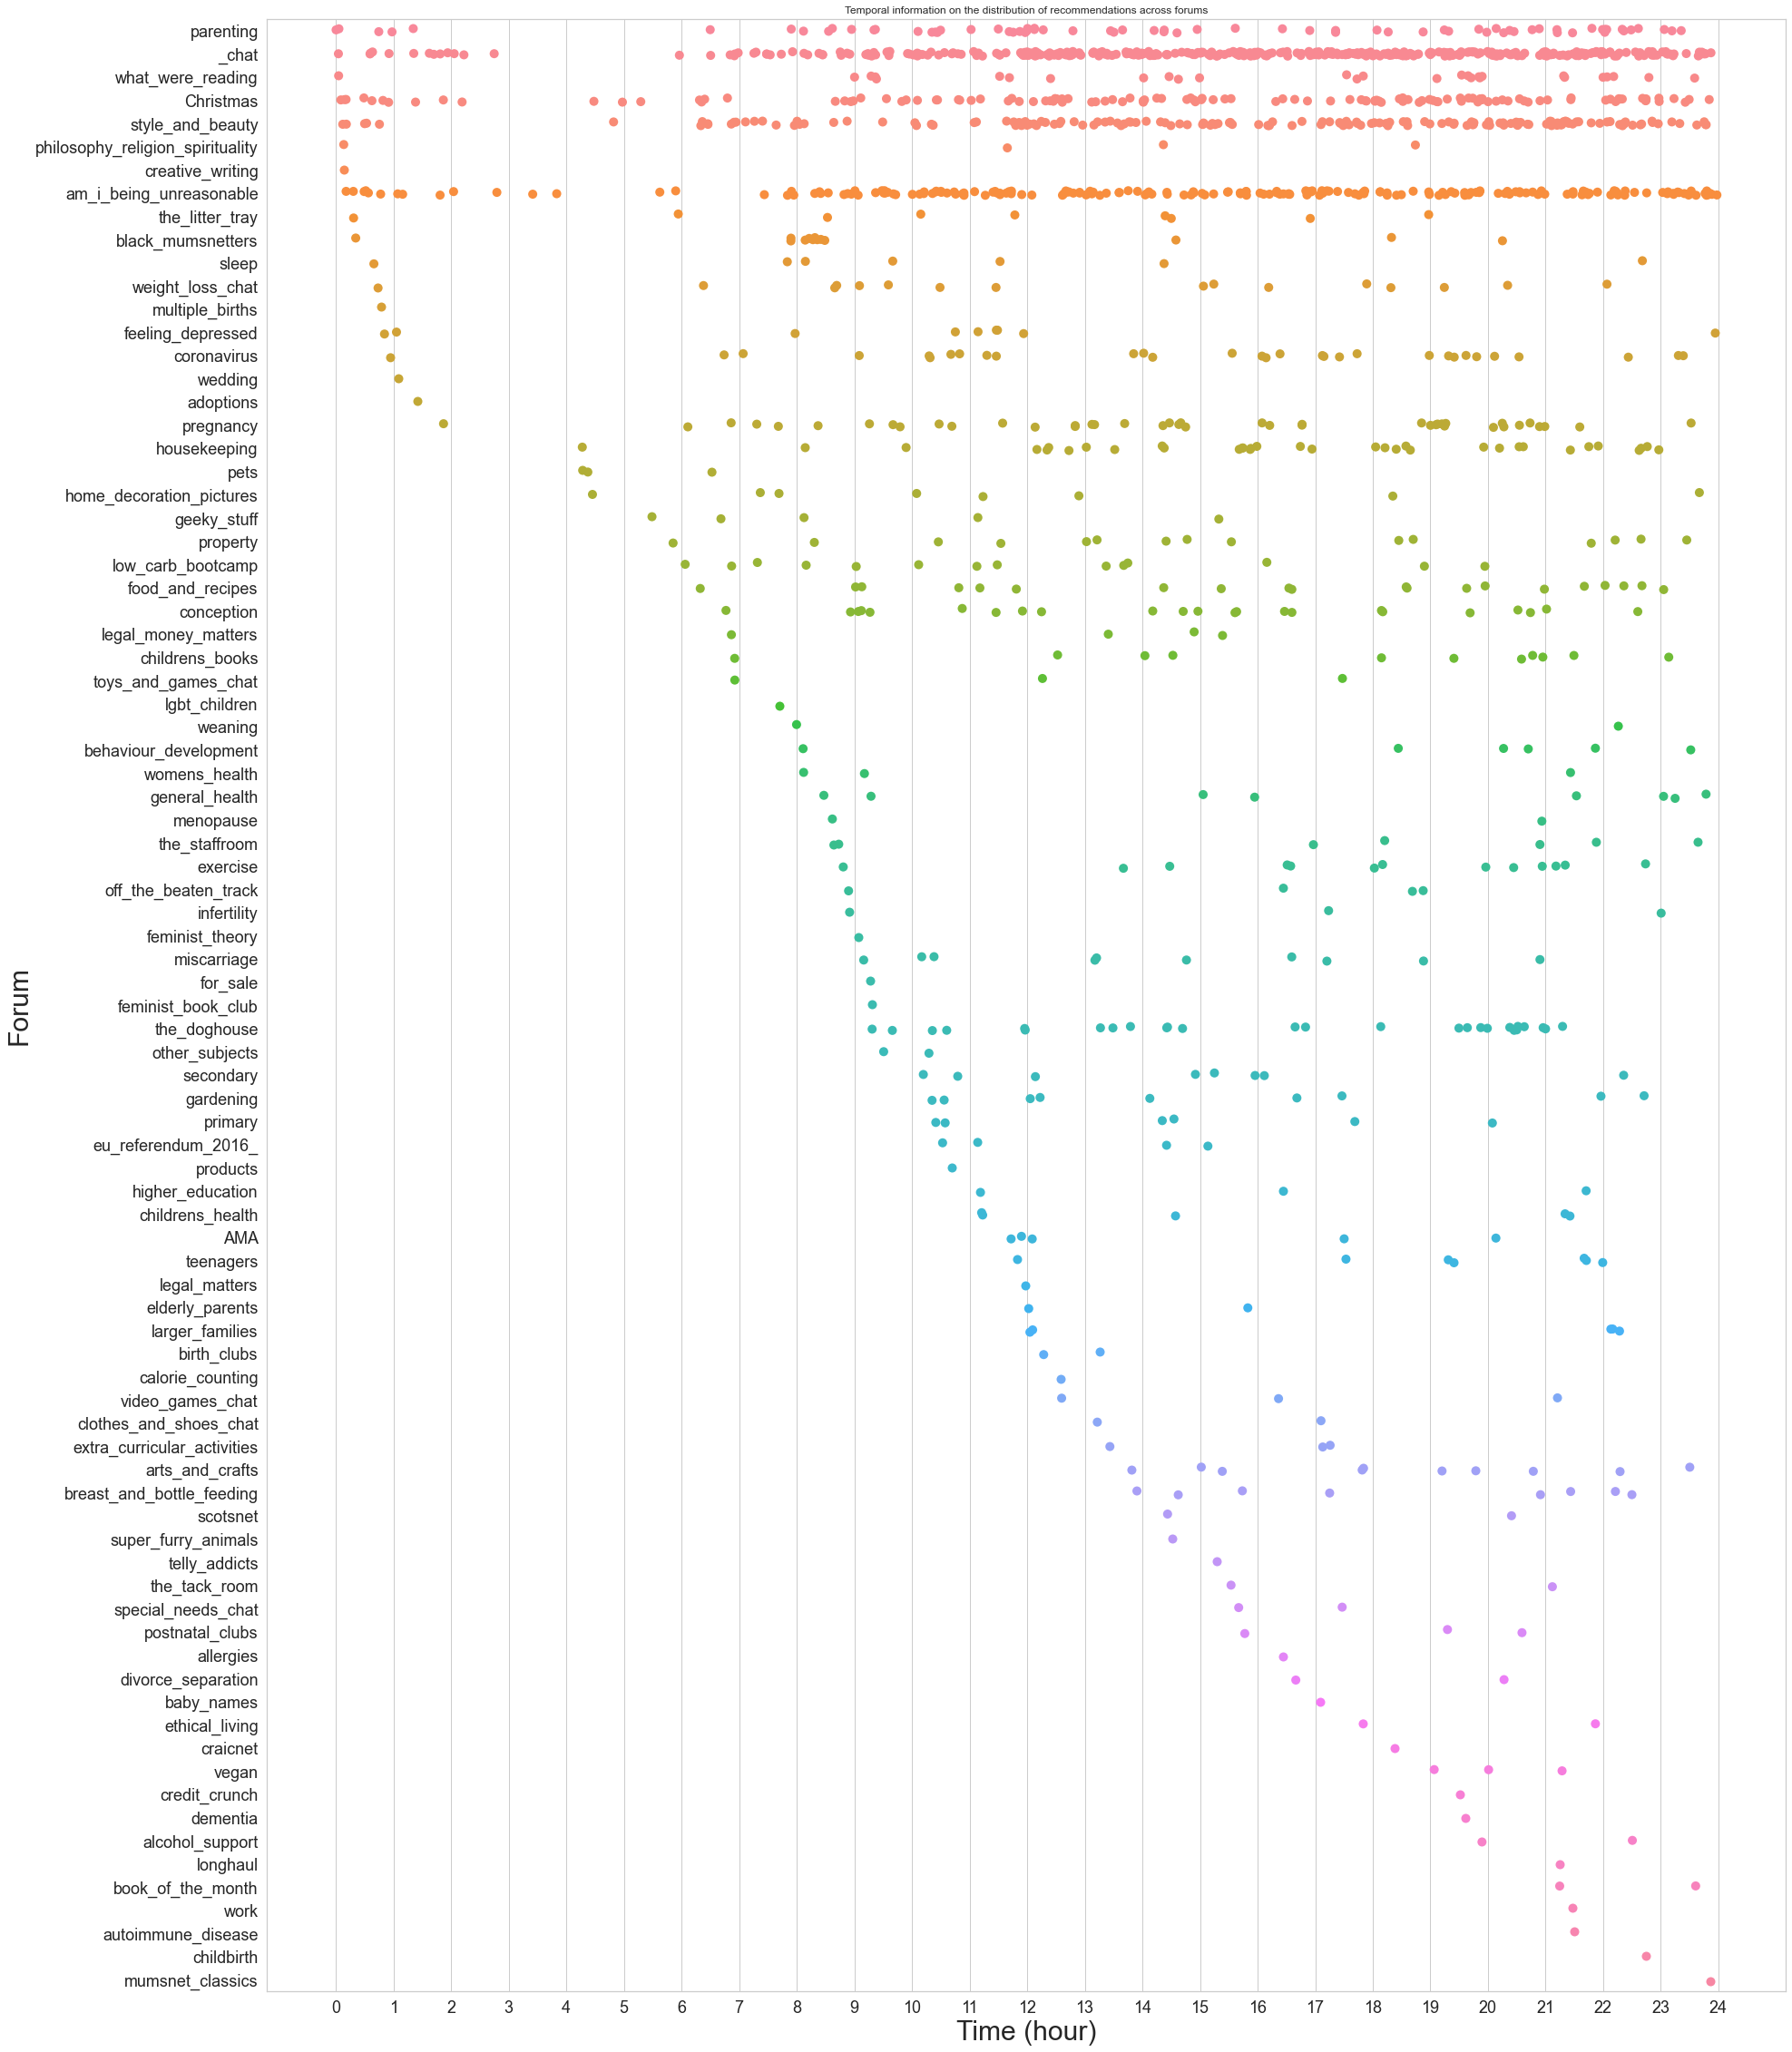

In [41]:
#Plot the time recommendations are made on each forum

os.chdir(viz)

sns.set_theme(style='whitegrid', palette='muted')
plt.figure(figsize=(30,40))

ax = sns.stripplot(data=times, x = 'Hours', y = 'Forum', s=10)

ax.set_xlabel('Time (hour)', fontsize=30)
ax.set_ylabel('Forum', fontsize=30)
ax.tick_params(labelsize=18)
ax.set_xticks(range(0,25,1))

plt.title('Temporal information on the distribution of recommendations across forums')
plt.savefig('Time of recommendations.pdf')